# EAF Coffea-Casa Benchmark Example 2 - Gateway and HTCondor

In [1]:
import numpy as np
%matplotlib inline
from coffea import hist
import coffea.processor as processor
import awkward as ak
from coffea.nanoevents import schemas
import pandas as pd

In [2]:
# This program plots a per-event array (in this case, Jet pT). In Coffea, this is not very 
#dissimilar from the event-level process.

class Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "")
        Jet_axis = hist.Bin("Jet_pt", "Jet_pt [GeV]", 100, 15, 60)
        
        self._accumulator = processor.dict_accumulator({
            'Jet_pt': hist.Hist("Counts", dataset_axis, Jet_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator.identity()
        
        dataset = events.metadata['dataset']
        Jet_pt = events.Jet.pt
        # As before, we can get the number of events by checking the size of the array. 
        #To get the number of jets, which varies per event, we need to count up the number in each event, 
        #and then sum those counts (count subarray sizes, sum them).
        output['cutflow']['all events'] += ak.size(Jet_pt, axis=0)
        output['cutflow']['all jets'] += ak.sum(ak.count(Jet_pt, axis=1))
        
        # .flatten() removes jaggedness; plotting jagged data is meaningless, we just want to plot flat jets.
        output['Jet_pt'].fill(dataset=dataset, Jet_pt=ak.flatten(Jet_pt))
        
        return output

    def postprocess(self, accumulator):
        return accumulator

# Connecting to the gateway
The code in the following cell imports the LPCGateway and connects to a cluster of HTCondor workers.
* gateway.new_cluster() starts a new cluster
* cluster.scale(N) specifies the number of workers in the cluster, here there are N workes in the cluster
* cluster.get_client() obtains the client that will connect your cluster to the scheduler, this is how the HTCondor workers are assigned to your tasks on the grid

In [3]:
from lpcdaskgateway import LPCGateway

gateway = LPCGateway()
cluster = gateway.new_cluster()
cluster

# Scale my cluster to 5 HTCondor workers
cluster.scale(5)

# Obtain a client for connecting to your cluster scheduler
# Your cluster should be ready to take requests
client = cluster.get_client()
client

INFO:lpcdaskgateway.LPCGateway: Creating LPCGatewayCluster 
INFO:lpcdaskgateway.GatewayCluster: Scaling: 5 HTCondor workers
INFO:lpcdaskgateway.GatewayCluster: Sandbox: /uscmst1b_scratch/lpc1/3DayLifetime/elisec/dask-gateway.e867703294f442af92f6f37b5b2ec3a4
INFO:lpcdaskgateway.GatewayCluster: Success! submitted HTCondor jobs to lpcschedd2.fnal.gov with  ClusterId 37113553


Client Scheduler: gateway://172.30.227.32:80/dask-gateway.e867703294f442af92f6f37b5b2ec3a4 Dashboard: https://dask-gateway.fnal.gov/clusters/dask-gateway.e867703294f442af92f6f37b5b2ec3a4/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Warning: running on HTCondor could take some time
The scheduler has to have available workers to connect to your cluster, this is what takes some time. After they connect, it should be much faster.

In [4]:
fileset = {'SingleMu' : ["root://eospublic.cern.ch//eos/root-eos/benchmark/Run2012B_SingleMu.root"]}

executor = processor.DaskExecutor(client=client)

run = processor.Runner(executor=executor,
                        schema=schemas.NanoAODSchema,
                        savemetrics=True
                      )

output, metrics = run(fileset, "Events", processor_instance=Processor())

metrics

[                                        ] | 0% Completed |  0.0s

/opt/conda/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/conda/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/conda/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


{'bytesread': 1612443666,
 'columns': ['nJet', 'Jet_pt'],
 'entries': 53446198,
 'processtime': 240.13143730163574,
 'chunks': 534}

<AxesSubplot:xlabel='Jet_pt [GeV]', ylabel='Counts'>

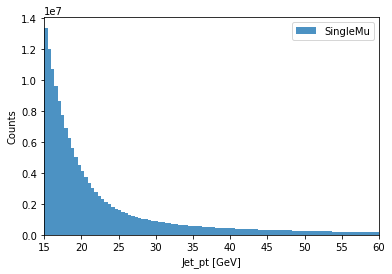

In [5]:
hist.plot1d(output['Jet_pt'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

In [6]:
for key, value in output['cutflow'].items():
    print(key, value)

all events 53446198
all jets 170952895


### Do not forget to shutdown your cluster
cluster.shutdown() does that gracefully

In [7]:
cluster.shutdown()

INFO:lpcdaskgateway.GatewayCluster: Shutting down HTCondor worker jobs
INFO:lpcdaskgateway.GatewayCluster: All jobs in cluster 37113553 have been marked for removal
